projectImg.png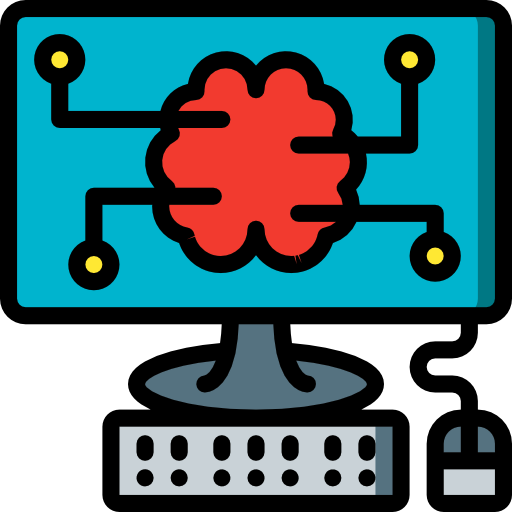

# Stock Market Prediction Web Application (Part 1)

Hello and welcome to my first posted project!  This project is taken from a recent book by Manuel Amunategui - "Monetizing Machine Learning" (Apress, 2018). This case study involves a popular pair trading strategy and developing a system that will alert us to possible trading opportunites.  ___NOTE:__  This is only a 'TOY' system and is not meant to be used as an actual trading system.  The only purpose of this project is to demonstrate how to use Python to develop an application that can be implemented as a web application!_


## Developing the Pair Trading Strategy

Pairs trading is a very well developed method of trading stocks, bonds, equities, options, futures, etc.  It is based on the premise that related tradeable instruments should rise and fall in unison.  For example, if the price of ABC Airlines increases, then the price of XYZ Airlines should also increase.  However, there will be times when the prices will diverge (for any reason).  When this happens, a pair trading strategy suggests that we should sell short the higher priced instrument and buy the lower priced instrument in the hopes that the two will revert back to their historical price levels.  Having a simultaneous long/short position can also lessen market volatility effects.

The downside to pairs trading is that market conditions may cause the pair to continue in their respective directions.  So it is indeed possible to lose money on both long and short sides of a pairs trade!

For this project, we will compare individual stocks that make up the [Dow Jones Industrial Average (Dow Jones Industrial Average - Wikipedia](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average) against the composite DJIA Index.  The DJIA is a price weighted stock index that is based on 30 major stocks contained in the New York Stock Exchange (NYSE) and NASDAQ exchanges.

Using a 90 day rolling window, we will evaluate the "strongest" and "weakest" stock.  The return of the strongest stock will be above the DJIA average return and thus will be considered for a short sale.  The return of the weakest stock will be below the DJIA average return and will be considered for being bought.

## Obtaining The Data

We will get data from the [Quandl](https://Quandl.com) website.  Quandl is is an excellent source for financial data, and they have free and paid options that should suit almost everyone.  One of the best things about Quandl is that they have a great [RESTful API](https://github.com/quandl/quandl-python) for accessing their data.  

It is easy to download the Quandl Python package using 

```
pip install quandl
import quandl
``` 

or you might need to use: 
```
pip3 install
import quandl
```

Once you have installed the Quandl Python package you will need to obtain an API so that you can authenticate your account and download data.  After registering on the Quandl site you can set the API key with the following command:

```
quandl.ApiConfig.api_key = "YOURAPIKEY"
```

Now we are ready to obtain our DJIA data using the Quandl Python package!

We will download the DJIA data, which is the weighted average Index.  Additionally, we will download each component stock that comprises the DJIA. We will create a table that has the ticker symbol, the date, and the adjusted closing price.  We have selected a one year time frame for this example (31 Dec 2016 to 31 Dec 2017) which can be modified as necessary.

Because we will combine two data sources we must make sure that the data types for each data source are the same.  The data from the DJI table is a 'string' type, while the data from the Quandl data is mixed with 'string', 'object', and 'float' types.  For compatability with analysis and calculations we will make sure that we have data in 'datetime' for the date column, 'string' for the ticker column, and 'float' for the adjusted_close column.

In [252]:
import quandl
import pandas as pd
import os
import time
quandl.ApiConfig.api_key = 'YOUR-API-KEY'

# get the data for the DJIA Index from the file folder and view the first few rows
DJI = pd.read_csv('/DJI.csv', header=None)
DJI = DJI.iloc[:, [0,5]]

DJI.rename(columns={2: 'ticker', 0: 'date', 5: 'adj_close'}, inplace=True)
DJI['ticker'] = 'DJI'
DJI = DJI[['ticker', 'date', 'adj_close']]

# Make sure columns have the correct data type
DJI['ticker'] = DJI['ticker'].astype(str)
DJI['date'] = pd.to_datetime(DJI['date'])
DJI['adj_close'] = DJI['adj_close'].astype(float)

DJI.head()



,ticker,date,adj_close
0,DJI,2017-12-29,24719.0
1,DJI,2017-12-28,24838.0
2,DJI,2017-12-27,24774.0
3,DJI,2017-12-26,24746.0
4,DJI,2017-12-22,24754.0


In [254]:
# get the table for daily stock prices and,
# filter the table for selected tickers, columns within a time range
# set paginate to True because Quandl limits tables API to 10,000 rows per call
              

data = quandl.get_table('WIKI/PRICES', ticker = ['AXP', 'BA', 'CAT', 'CSCO', 'MMM', 'CVX',
                                                 'AAPL', 'MSFT', 'WMT','KO', 'DIS','DOW',
                                                 'XOM', 'GS', 'HD', 'IBM', 'INTC', 'JNJ',
                                                 'JPM','MCD', 'MRK', 'NKE', 'PFE', 'PG',
                                                 'TRV', 'UTX', 'UNH', 'VZ', 'V', 'WBA'],
                        qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                        date = { 'gte': '2016-12-31', 'lte': '2017-12-31' }, 
                        paginate=True)

# Make sure columns have the correct data type
data['ticker'] = data['ticker'].astype(str)
data['date'] = pd.to_datetime(data['date'])
data['adj_close'] = data['adj_close'].astype(float)

data.head()


,ticker,date,adj_close
None,,,
0,XOM,2017-12-29,83.64
1,XOM,2017-12-28,84.02
2,XOM,2017-12-27,83.90
3,XOM,2017-12-26,83.98
4,XOM,2017-12-22,83.97


In [255]:


# Combine DJ Index with DJ Component stocks
data = data.append(DJI)

# create a new dataframe with 'date' column as index
new = data.set_index('date')

# use pandas pivot function to sort adj_close by tickers
data = new.pivot(columns='ticker')

data.columns = data.columns.droplevel()

data.head()



ticker,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DJI,DOW,GS,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,114.715378,74.162246,152.668443,91.258087,29.484966,114.381567,105.285393,19882.0,56.386279,239.298230,...,31.756236,81.645971,120.235551,159.581286,108.929230,79.081715,53.359309,81.821163,67.291215,87.567241
2017-01-04,114.586983,75.372857,154.273227,90.850294,29.311184,114.352450,106.635206,19942.0,56.836586,240.843560,...,32.035306,81.936871,119.589123,160.035961,108.998029,79.728295,53.300650,81.840888,67.683241,86.603799
2017-01-05,115.169696,74.443792,154.360760,90.296862,29.379349,113.857459,106.575655,19899.0,56.582064,239.050581,...,32.343245,82.479884,117.679675,160.302836,109.440312,80.663349,53.417967,81.890202,67.830251,85.312787
2017-01-06,116.453639,74.592047,154.740073,90.335699,29.437777,113.401292,108.163670,19964.0,56.229650,242.596914,...,32.218145,82.450794,117.620005,160.530174,110.619731,81.777456,52.632926,81.959241,66.899190,85.264615
2017-01-09,117.520300,74.977510,153.981448,89.685174,29.389087,112.430723,107.548315,19887.0,56.572275,240.605817,...,32.208521,81.839904,116.675226,160.075498,109.587739,81.319877,52.059755,81.416791,67.340219,83.857990


In [258]:
pd.DataFrame({"PercentChange": data['AAPL'].pct_change(), "PercentChangeCumSum": data['AAPL'].cumsum(), "Price": data['AAPL']}).head()

,PercentChange,PercentChangeCumSum,Price
date,,,
2017-01-03,NaN,114.715378,114.715378
2017-01-04,-0.001119,229.302361,114.586983
2017-01-05,0.005085,344.472057,115.169696
2017-01-06,0.011148,460.925697,116.453639
2017-01-09,0.009160,578.445996,117.520300


In [259]:
# Use last 90 days of data
data = data.tail(90)

In [262]:
# Loop through each symbol and compare last percentage change CumSum against DJI and store in dictionary for comparison
stock1 = 'DJI'
last_distance_from_index = {}
temp_series1 = data[stock1].pct_change().cumsum()

for stock2 in list(data):
    if(stock2 != stock1):
        temp_series2 = data[stock2].pct_change().cumsum()
        
        # subtract the stock-index, if stock is strong compared to index it will be a positive value
        diff = list(temp_series2 - temp_series1)
        last_distance_from_index[stock2] = diff[-1]

print(last_distance_from_index)
        
        
        

{'AAPL': -0.06447390723706314, 'AXP': 0.03269316694771918, 'BA': 0.0977434777786893, 'CAT': 0.20247803307341627, 'CSCO': 0.10094694926221315, 'CVX': 0.03828914053468857, 'DIS': -0.06264213286508513, 'DOW': -0.09383434504066235, 'GS': 0.017622517665278448, 'HD': 0.12297109022689945, 'IBM': -0.033635622484683325, 'INTC': 0.1803519577543673, 'JNJ': -0.06007558003530711, 'JPM': 0.038229878255500394, 'KO': -0.10869254705059705, 'MCD': -0.03644045985155231, 'MMM': 0.03931701357877526, 'MRK': -0.2119677362799952, 'MSFT': 0.046773207997522936, 'NKE': 0.03720090015629296, 'PFE': -0.028446409975546927, 'PG': -0.12207722383113784, 'TRV': -0.05008110325917747, 'UNH': 0.009642117499063407, 'UTX': -0.034623676001049986, 'V': -0.022500402890887283, 'VZ': -0.02853927744775575, 'WBA': -0.22967411581115615, 'WMT': 0.0945146911358491, 'XOM': -0.03674116772858749}


Weakest symbol: WBA
Strongest symbol: CAT


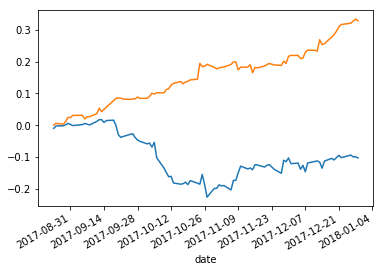

In [277]:
# Use Lamba Functions to find weakest and strongest values in the last_distance_from_index dictionary

# Find weakest symbol
weakest_symbol = min(last_distance_from_index.items(), key = lambda x: x[1])

print('Weakest symbol: %s' % weakest_symbol[0])
data['WBA'].pct_change().cumsum().plot()
#plt.show()

# Now find the strongest symbol
strongest_symbol = max(last_distance_from_index.items(), key = lambda x: x[1])

print('Strongest symbol: %s' % strongest_symbol[0])
data['CAT'].pct_change().cumsum().plot()

In [278]:
# For dollar-neutral trades, set a budget value and total dollar amount willing to trade
trading_budget = 10000

# Get the last trading price for both stock recommendations
short_symbol = strongest_symbol[0]
short_last_close = data[strongest_symbol[0]][-1]
print('Strongest symbol is %s, last price: $%f' % (strongest_symbol[0], short_last_close))

long_symbol = weakest_symbol[0]
long_last_close = data[weakest_symbol[0]][-1]
print('Weakest symbol is %s, last price: $%f' % (weakest_symbol[0], long_last_close))


Strongest symbol is CAT, last price: $157.580000
Weakest symbol is WBA, last price: $72.620000


In [280]:
# Find number of shares to short
print('For %s, at $%f, you need to short %i shares' % 
      (short_symbol, short_last_close, (trading_budget * 0.5) / short_last_close))

For CAT, at $157.580000, you need to short 31 shares


In [281]:
# Find number of shares to buy (go long)
print('For %s, at $%f, you need to buy %i shares' % 
      (long_symbol, long_last_close, (trading_budget * 0.5) / long_last_close))

For WBA, at $72.620000, you need to buy 68 shares


## Next Steps

This concludes the first part of this project.  Next we will build a Python Flask web application that will use our recommendation system to suggest trades to a user.  The user will supply a total allowable trading budget and the application will return the number of shares to buy and sell for a dollar neutral system.

The first part of this project has been very helpful.  One of the things that I have liked is using the Jupyter Notebook.  Using the notebook has shown me the importance of planning an outline of the application that you want to develope.  It is easy to write out what you want to do and then fill in code in chunks that are small as needed.  I hope to expand on this idea in future projects.

The Jupyter Notebook for this project will be posted on my github page.  Any input or suggestions for improvements are always greatly appreciated.

See you soon!